In [1]:
import os
import math
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"
import torch as t
import cv2 
import sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from matplotlib.patches import Patch

os.environ["CUDA_VISIBLE_DEVICES"]="1"
sys.path.append("..")
from src import *
plt.style.use("default")

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import random

2024-04-27 11:39:43.005807: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 11:39:43.049365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 11:39:43.923775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
# get data csv
high_quality_only = True
data = get_data_csv(high_quality_only=high_quality_only)
data = data[data["Group"] == "Melanoma"]
data["Coarse tumor stage"] = data["Float tumor stage"] > 0.5
data = data.reset_index().drop("index", axis=1)

In [20]:
# rules for pfs label
def get_group(histo_id):
    tfp = pd.read_csv("/data_nfs/je30bery/utils/tfp.csv").set_index("Histo-ID")
    pfs = tfp.loc[histo_id]["PFS"].astype(float)
    if math.isnan(pfs):
        pfs = tfp.loc[histo_id]["tumorfrei seit Erstdiagnose"]
    if pfs > 3 and pfs < 5:
        return np.nan
    return pfs >= 5

In [21]:
# manual adjustments according to comments in table
data.reset_index(inplace=True)
data["new_label"] = data["Histo-ID"].apply(lambda x: get_group(x))
data.set_index("Histo-ID", inplace=True)  # Set the index in place

data.loc["B104", "new_label"] = True
data.loc["B148", "new_label"] = True

# nach <5 verstorben aber nicht an Melanom
data.loc["B340", "new_label"] = np.nan
data.loc["B345", "new_label"] = np.nan
data = data.dropna(subset=["new_label"], axis=0)
data["new_label"] = data["new_label"].astype(np.uint8)
data = balance(data, split_by="Group", variable="new_label")
data.reset_index(inplace=True)

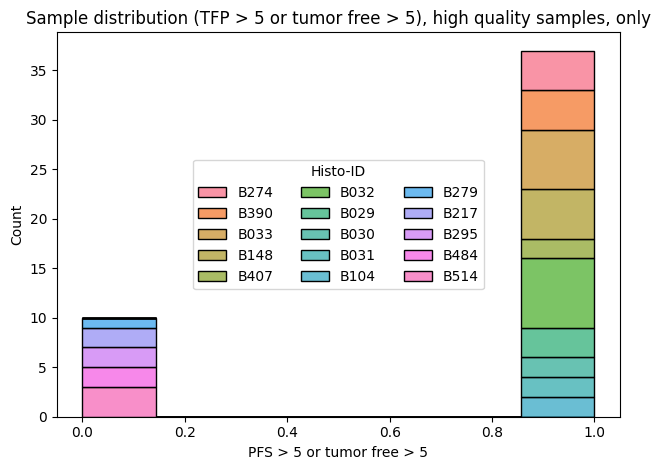

In [22]:
f, ax = plt.subplots(1)
sns.histplot(data, hue="Histo-ID", x="new_label", multiple="stack", ax=ax)
sns.move_legend(ncols=3, obj=ax, loc="center")
plt.xlabel("PFS > 5 or tumor free > 5")

if high_quality_only:
    plt.title("Sample distribution (TFP > 5 or tumor free > 5), high quality samples, only")
    plt.tight_layout()
    plt.savefig("sample_distri_high_quality_samples.pdf", bbox_inches="tight")
else:
    plt.title("Sample distribution (TFP > 5 or tumor free > 5), all samples")
    plt.tight_layout()
    plt.savefig("sample_distri_all.pdf", bbox_inches="tight")

In [7]:
# get effnet 
def get_features(effnet, x):
    x = effnet.features(x.cuda())
    x = effnet.avgpool(x)
    x = effnet.flatten(x)
    return x.detach().cpu().numpy()

In [8]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

effnet = EfficientnetWithFinetuning(indim=len(markers))
effnet.load_state_dict(t.load("../data/models/finetuned_effnet_with_LR_reduction_on_plateau.pt", map_location="cpu"))
effnet = effnet.cuda()
effnet = effnet.eval()

dl = t.utils.data.DataLoader(MelanomaData(markers, classify=False, data=data, mode="val"), batch_size=1, shuffle=False)
it = iter(dl)
features = list()
labels = list()
while True:
    try:
        x, y = next(it)
        labels.append(y.detach().cpu().numpy()[0])
        features.append(get_features(effnet, x))
    except StopIteration:
        break
conc = np.concatenate(features)

In [11]:
def get_oob(X, y):
    clf = RandomForestClassifier(max_depth=2, random_state=0, oob_score=True)
    clf.fit(X, y)
    return clf.oob_score_

In [13]:
y = data["new_label"].to_numpy().astype(int)
X = conc
actual_score = get_oob(X, y)
print(actual_score)

0.8134328358208955


In [14]:
# create z scores
oobs = list()
histo_ids = np.unique(data["Histo-ID"])
mapping = [np.unique(data.set_index("Histo-ID").loc[id]["new_label"])[0] for id in histo_ids]

# randomly shuffle the pfs labels, but keep the same label within one histo-id (=same peace of tissue)
for i in tqdm(range(1000)):
    random.shuffle(mapping)
    map = {histo_ids[i]: mapping[i] for i in range(len(histo_ids))}
    y = data["Histo-ID"].apply(lambda x: map[x])
    oobs.append(get_oob(X, y))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.56it/s]


In [15]:
z = (actual_score - np.mean(oobs)) / np.std(oobs) 

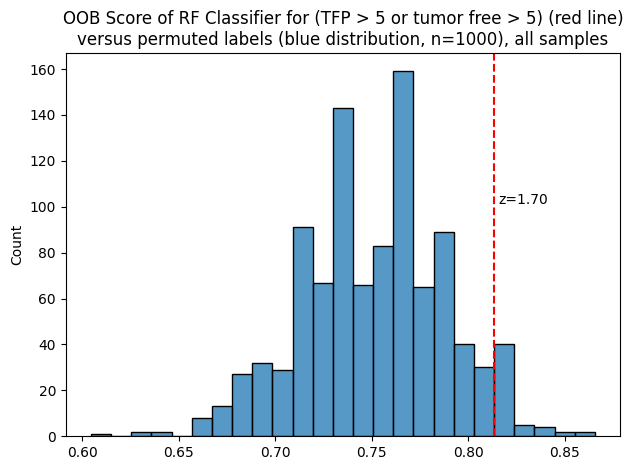

In [16]:
sns.histplot(oobs)
plt.axvline(x=actual_score, color='r', linestyle='--')
plt.text(actual_score + 0.002, 100, f"z={z:.2f}", rotation=0, verticalalignment='bottom')
if high_quality_only:
    plt.title("OOB Score of RF Classifier for (TFP > 5 or tumor free > 5) (red line)\nversus permuted labels (blue distribution, n=1000), high quality samples, only")
    plt.tight_layout()
    plt.savefig("oob_z_high_quality.pdf", bbox_inches="tight")
else:
    plt.title("OOB Score of RF Classifier for (TFP > 5 or tumor free > 5) (red line)\nversus permuted labels (blue distribution, n=1000), all samples")
    plt.tight_layout()
    plt.savefig("oob_z_all.pdf", bbox_inches="tight")

____________________________________
### old

In [17]:
X = conc[np.where(data["split"] == "train")]
X_val = conc[np.where(data["split"] == "val")]

labels = data["Coarse tumor stage"].values
y = labels[np.where(data["split"] == "train")]
y_val = labels[np.where(data["split"] == "val")]

KeyError: 'split'

In [ ]:
data["Histo-ID"].values

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
y_pred = clf.predict(X_val)
print(accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)) 
print(y_val)
print(y_pred)

In [ ]:
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X_val) > 0.5
print(accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)) 
print(y_val)
print(y_pred)

In [ ]:
pca = PCA(2)
transform = pca.fit_transform(conc)
df = pd.DataFrame()
df["PC1"] = transform[:, 0]
df["PC2"] = transform[:, 1]
df["Coarse tumor stage"] = labels
df["Coarse tumor stage"].replace({True: "T3, T4", False: "T1, T2"}, inplace=True)
df["Group"] = data["Group"].values
df["Coarse tumor stage"].iloc[np.where(df["Group"] == "Nevus")] = "Nevus"

In [ ]:
sns.set_theme("paper")
palette = {"T1, T2": "#f57d05", "T3, T4": "#8634b3"}
f, ax = plt.subplots(1,1, figsize=(6,6))
f.patch.set_facecolor('white')
sns.set_theme("paper")
sns.scatterplot(df, x="PC1", y="PC2", palette=palette, hue="Coarse tumor stage", hue_order=["T1, T2", "T3, T4"])
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
ax.legend(handles=legend_handles, loc=(0.35,1), ncol=3, frameon=False)
plt.tight_layout()
plt.savefig("../result_plots/PCA_on_EffNet_features.pdf", bbox_inches="tight")

In [ ]:
pca = PCA(2)
transform = pca.fit_transform(conc[np.where(data["Group"] == "Melanoma")])

In [ ]:
df = pd.DataFrame()
df["PC1"] = transform[:, 0]
df["PC2"] = transform[:, 1]
df["Coarse tumor stage"] = labels
df["Coarse tumor stage"].replace({True: "T3, T4", False: "T1, T2"}, inplace=True)
df["Group"] = data["Group"].values

In [ ]:
palette = {"T1, T2": "#f57d05", "T3, T4": "#8634b3"}
f, ax = plt.subplots(1,1, figsize=(6,6))
sns.set_theme("paper")
sns.scatterplot(df, x="PC1", y="PC2", hue="Coarse tumor stage", palette=palette, ax=ax)
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
ax.legend(handles=legend_handles, loc=(0.275, 1), ncol=2, frameon=False)
plt.tight_layout()